# Data Science Capstone Project - Exploring areas and venues of Sydney NSW, Australia

**Harry Ngo**   
This notebook will be used for the [Applied Data Science Capstone](https://www.coursera.org/learn/applied-data-science-capstone/) project from IBM and Coursera.
## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

New South Wales (NSW) is one of the major states in Australia, being most populous with over 8.1 million residents. There are many cities and towns within NSW, where its capital city Sydney is home to almost two-thirds of the NSW population. 

The aim of the project is to explore different areas of Sydney and find optimal locations for a new resident based on the top common venues in each borough.     
This report will be targeted to people interested in becoming a resident in Sydney NSW, Australia, as well as homebuyers, people staying over a long period and other similar conditions. Others who are interested in learning about different boroughs of Sydney may also benefit from this.

With Australia being a multicultural country, its landscape is constantly evolving, seeing increases in different ethnic communities and venues. Sydney boroughs will be discussed such that stakeholders can choose an optimal living location based on their interests. 

## Data <a name="data"></a>

Before we begin our analysis, the following libraries will be imported.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Retrieve _Second-level Administrative Divisions, Australia, 2015_ JSON file which contains boroughs of different states and territories in Australia.    
This includes aboriginal councils, boroughs, cities, government and district councils, municipalities, rural cities, shires and territories.    
The relevant information from the exported JSON file includes the state/territory, borough/council and the multiple coordinates of each division. 

In [3]:
!wget -q -O 'australia.json' https://geo.nyu.edu/download/file/stanford-fc944xn1421-geojson.json

In [4]:
with open('australia.json') as json_data:
    australia_data = json.load(json_data)

In [5]:
borough_data = australia_data['features']

By exploring the data, the geometry is of type _MultiPoint_ and contains several coordinates. 'name_1' refers to the State or Territory the location is in, with 'name_2' being a borough/council.

Transform the data into a _pandas_ dataframe

In [6]:
# define the dataframe columns
column_names = ['State/Territory', 'Borough', 'Latitude', 'Longitude']
boroughs = pd.DataFrame(columns = column_names)
boroughs

,State/Territory,Borough,Latitude,Longitude


In [7]:
# loop through the data and fill the dataframe one row at a time
for data in borough_data:
    borough = neighbourhood_name = data['properties']['name_1']
    neighbourhood_name = data['properties']['name_2']
    
    neighbourhood_latlon = data['geometry']['coordinates']
    neighbourhood_lat = neighbourhood_latlon[0][0][0][1] # pick first multipoint to keep it simple
    neighbourhood_lon = neighbourhood_latlon[0][0][0][0]
    
    boroughs = boroughs.append({'State/Territory': borough,
                               'Borough': neighbourhood_name,
                               'Latitude': neighbourhood_lat,
                               'Longitude': neighbourhood_lon}, ignore_index=True)

In [8]:
boroughs.head()

,State/Territory,Borough,Latitude,Longitude
0,Ashmore and Cartier Islands,n.a.1,-12.243176,123.135139
1,Australian Capital Territory,Acton,-35.298828,149.085983
2,Australian Capital Territory,Ainslie,-35.277584,149.142258
3,Australian Capital Territory,Amaroo,-35.169235,149.113922
4,Australian Capital Territory,Aranda,-35.258518,149.088074


In [9]:
print('The dataframe has {} states/territories and {} boroughs.'.format(
        len(boroughs['State/Territory'].unique()),
        boroughs.shape[0]
    )
)

The dataframe has 11 states/territories and 1395 boroughs.


In [10]:
boroughs['State/Territory'].value_counts()

Queensland                      475
Victoria                        208
New South Wales                 199
Western Australia               141
South Australia                 127
Australian Capital Territory    109
Northern Territory               95
Tasmania                         38
Ashmore and Cartier Islands       1
Jervis Bay Territory              1
Coral Sea Islands                 1
Name: State/Territory, dtype: int64

In [11]:
# retrieve only NSW state data
df_nsw = boroughs[boroughs['State/Territory'].str.contains('New South Wales')].reset_index(drop=True)
df_nsw.head()

,State/Territory,Borough,Latitude,Longitude
0,New South Wales,Albury,-35.914963,146.971710
1,New South Wales,Armidale Dumaresq Bal,-30.589890,151.632751
2,New South Wales,Armidale Dumaresq,-30.483726,151.661728
3,New South Wales,Ashfield,-33.870983,151.119431
4,New South Wales,Auburn,-33.850048,151.081467


In [12]:
df_nsw.shape

(199, 4)

From above, we can see there are 199 boroughs of New South Wales. Looking through the data, there is no quick method to check which boroughs are within Sydney. Instead, rows were manually removed which were not in the vicinity of Sydney, which was specified to be within an 80 km radius of Sydney. This was completed using Google Maps to investigate whether the borough was within the specified vicinity.

In [13]:
# dropping specified rows by index where borough is not within an 80 km radius of Sydney
df_sydney = df_nsw.drop([0,1,2,5,6,10,11,15,16,17,21,22,23,24,25,26,28,29,30,32,33,40,41,42,43,44,45,46,
                         47,48,49,50,51,52,53,54,55,56,57,58,59,60,63,64,65,66,69,70,71,72,73,74,75,76,
                         77,78,79,80,81,82,88,89,90,91,92,93,96,97,98,99,100,102,104,105,106,109,110,111,
                         112,115,116,117,119,120,121,122,123,124,125,126,127,128,130,131,132,133,134,142,
                         143,144,145,147,148,151,152,153,154,155,163,164,165,166,167,168,169,170,171,172,
                         173,174,175,176,177,178,179,180,181,182,184,186,187,188,189,190,191,192,193,195,
                         196,197,198])
# see resulting data frame
df_sydney = df_sydney.reset_index(drop=True)
df_sydney

,State/Territory,Borough,Latitude,Longitude
0,New South Wales,Ashfield,-33.870983,151.119431
1,New South Wales,Auburn,-33.850048,151.081467
2,New South Wales,Bankstown - North-East,-33.934044,151.038269
3,New South Wales,Bankstown - North-West,-33.929268,150.978989
4,New South Wales,Bankstown - South,-33.929268,150.978989
5,New South Wales,Baulkham Hills - Central,-33.732754,151.026932
6,New South Wales,Baulkham Hills - North,-33.597393,151.006332
7,New South Wales,Baulkham Hills - South,-33.793343,150.999817
8,New South Wales,Blacktown - South-East,-33.741291,150.865662
9,New South Wales,Blacktown - North,-33.741291,150.865662


In [14]:
df_sydney.shape

(58, 4)

We can see from the final data frame, there are some similar boroughs e.g. Bankstown - North-East, Bankstown - West, etc. A further investigation when plotting the coordinates on a map of Sydney shows that picking out the first MultiPoint was not very accurate. As I cannot find any data sets online which have correct single coordinates, I cleaned up the data frame manually. I removed all other duplicates of the same borough (e.g. east, west) as they overlapped other boroughs.

Cleaning up the data again...

In [15]:
# removing duplicate boroughs or overlapping ones (again)
df_sydney2 = df_sydney.drop([3,4,6,7,9,10,15,20,22,25,33,39,40,41,43,50,51,52,53,54])
df_sydney2.reset_index(drop=True)

,State/Territory,Borough,Latitude,Longitude
0,New South Wales,Ashfield,-33.870983,151.119431
1,New South Wales,Auburn,-33.850048,151.081467
2,New South Wales,Bankstown - North-East,-33.934044,151.038269
3,New South Wales,Baulkham Hills - Central,-33.732754,151.026932
4,New South Wales,Blacktown - South-East,-33.741291,150.865662
5,New South Wales,Botany Bay,-33.967484,151.218933
6,New South Wales,Burwood,-33.871883,151.094498
7,New South Wales,Camden,-33.967754,150.815094
8,New South Wales,Campbelltown - North,-34.037361,150.889984
9,New South Wales,Canada Bay - Concord,-33.869656,151.111618


(In this step, I manually altered the data set, cleaning names and the coordinates. To have a better variety of venues, Sutherland Shire coordinates were chosen to be in the suburb Cronulla.    
See final data set used in repository [here](https://github.com/ngoharry19/Coursera_Capstone/blob/master/sydney_data.csv).

In [3]:
# to save computation, we can save the new data frame into a csv file
df_sydney3 = pd.read_csv('sydney_data.csv')
df_sydney3.head()

,State/Territory,Borough,Latitude,Longitude
0,New South Wales,Ashfield,-33.8889,151.1249
1,New South Wales,Auburn,-33.8606,151.0247
2,New South Wales,Bankstown,-33.9182,151.0350
3,New South Wales,Baulkham Hills,-33.7619,150.9929
4,New South Wales,Blacktown,-33.7668,150.9053


In [4]:
df_sydney3.shape

(38, 4)

## Methodology <a name="methodology"></a>

After retrieving the boroughs in our specified Sydney region as well as the longitude and latitude for each borough, we will now use Foursquare API for exploratory analysis to find venues near our neighbourhoods.    
We will then use K-means clustering to create clusters of neighbourhoods which have similar characteristics.

**Use geopy library to get the latitude and longitude values of Sydney**

In [5]:
# Get geographical coordinates of Toronto
address = "Sydney, AU"

geolocator = Nominatim(user_agent="sydney_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Sydney, AU are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Sydney, AU are -33.8548157, 151.2164539.


**Create a map of Sydney with boroughs superimposed on top**

In [6]:
# create map of Sydney using latitude and longitude values
map_sydney = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, state, borough in zip(df_sydney3['Latitude'], df_sydney3['Longitude'], df_sydney3['State/Territory'], df_sydney3['Borough']):
    label = '{}, {}'.format(borough, state)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sydney)  
    
map_sydney

**Define Foursquare Credentials (removed for privacy)**

In [7]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' 

**Exploring the first borough in our data frame**

In [8]:
df_sydney3.loc[0, 'Borough']

'Ashfield'

In [9]:
neighborhood_latitude = df_sydney3.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_sydney3.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_sydney3.loc[0, 'Borough'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Ashfield are -33.8889, 151.1249.


**Get the top 100 venues that are in Ashfield within 1000m radius**

In [10]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 1000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION,
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    LIMIT)

# create json file for results
results = requests.get(url).json()

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Cleaning the JSON file and structuring it into a _pandas_ data frame.

In [12]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Manmaruya,Japanese Restaurant,-33.889603,151.126183
1,Choo Choo Train,Chinese Restaurant,-33.888275,151.124196
2,Thai Number 1,Thai Restaurant,-33.887142,151.125685
3,New Shanghai Night 新夜上海,Shanghai Restaurant,-33.888461,151.124393
4,Taste of Shanghai,Dumpling Restaurant,-33.888279,151.123992


In [13]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

38 venues were returned by Foursquare.


**Let's create a function to repeat the process to all other neighbourhoods/suburbs in Sydney region**

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
sydney_venues = getNearbyVenues(names=df_sydney3['Borough'],
                                   latitudes=df_sydney3['Latitude'],
                                   longitudes=df_sydney3['Longitude']
                                  )

Ashfield
Auburn
Bankstown
Baulkham Hills
Blacktown
Botany Bay
Burwood
Camden
Campbelltown
Canterbury
Concord
Drummoyne
Fairfield
Gosford
Holroyd
Hornsby
Hunters Hill
Hurstville
Kogarah
Ku-ring-gai
Lane Cove
Leichhardt
Liverpool
Manly
Marrickville
Mosman
North Sydney
Parramatta
Penrith
Pittwater
Randwick
Rockdale
Ryde
Strathfield
Sutherland Shire
Warringah
Waverley
Woollahra


In [16]:
print(sydney_venues.shape)
sydney_venues.head()

(890, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ashfield,-33.8889,151.1249,Manmaruya,-33.889603,151.126183,Japanese Restaurant
1,Ashfield,-33.8889,151.1249,Choo Choo Train,-33.888275,151.124196,Chinese Restaurant
2,Ashfield,-33.8889,151.1249,Thai Number 1,-33.887142,151.125685,Thai Restaurant
3,Ashfield,-33.8889,151.1249,New Shanghai Night 新夜上海,-33.888461,151.124393,Shanghai Restaurant
4,Ashfield,-33.8889,151.1249,Taste of Shanghai,-33.888279,151.123992,Dumpling Restaurant


In [17]:
sydney_venues.groupby('Neighbourhood').count().head()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Ashfield,37,37,37,37,37,37
Auburn,5,5,5,5,5,5
Bankstown,53,53,53,53,53,53
Baulkham Hills,18,18,18,18,18,18
Blacktown,39,39,39,39,39,39


(Note: we see Botany Bay and Warringah have no count and hence are removed from the following analysis. This is most likely due to the coordinates of the areas.)

In [18]:
print('There are {} uniques categories.'.format(len(sydney_venues['Venue Category'].unique())))

There are 143 uniques categories.


**Analyzing each neighborhood...**

In [19]:
# one hot encoding
sydney_onehot = pd.get_dummies(sydney_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sydney_onehot['Neighbourhood'] = sydney_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [sydney_onehot.columns[-1]] + list(sydney_onehot.columns[:-1])
sydney_onehot = sydney_onehot[fixed_columns]

sydney_onehot.head()

,Neighbourhood,American Restaurant,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bangladeshi Restaurant,Bar,Beach,Bed & Breakfast,Beijing Restaurant,Big Box Store,Boat or Ferry,Bookstore,Bowling Alley,Bowling Green,Brazilian Restaurant,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Café,Camera Store,Cantonese Restaurant,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Coffee Shop,Convenience Store,Cosmetics Shop,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food Court,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Garden,Gastropub,General Entertainment,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hookah Bar,Hospital,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lebanese Restaurant,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Movie Theater,Multiplex,Music Store,Music Venue,Nature Preserve,Noodle House,Organic Grocery,Other Nightlife,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Restaurant,River,Salad Place,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shopping Mall,Soccer Field,South American Restaurant,South Indian Restaurant,Souvlaki Shop,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,Ashfield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Ashfield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Ashfield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,Ashfield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Ashfield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category**

In [20]:
sydney_grouped = sydney_onehot.groupby('Neighbourhood').mean().reset_index()
sydney_grouped.head()

,Neighbourhood,American Restaurant,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bangladeshi Restaurant,Bar,Beach,Bed & Breakfast,Beijing Restaurant,Big Box Store,Boat or Ferry,Bookstore,Bowling Alley,Bowling Green,Brazilian Restaurant,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Café,Camera Store,Cantonese Restaurant,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Coffee Shop,Convenience Store,Cosmetics Shop,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food Court,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Garden,Gastropub,General Entertainment,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hookah Bar,Hospital,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lebanese Restaurant,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Movie Theater,Multiplex,Music Store,Music Venue,Nature Preserve,Noodle House,Organic Grocery,Other Nightlife,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Restaurant,River,Salad Place,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shopping Mall,Soccer Field,South American Restaurant,South Indian Restaurant,Souvlaki Shop,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,Ashfield,0.0,0.054054,0.027027,0.0,0.0,0.000000,0.0,0.027027,0.0,0.0,0.027027,0.000000,0.0,0.0,0.000000,0.0,0.0,0.027027,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.054054,0.0,0.0,0.081081,0.0,0.000000,0.000000,0.027027,0.027027,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.027027,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.081081,0.054054,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.027027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.054054,0.027027,0.000000,0.000000,0.027027,0.0,0.027027,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.027027,0.0,0.000000,0.054054,0.0,0.0,0.000000,0.0,0.000000,0.027027,0.0,0.000000,0.027027,0.0,0.0,0.000000,0.0,0.0,0.054054,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.054054,0.027027,0.0,0.0,0.0,0.027027,0.000000,0.0,0.027027,0.0,0.0,0.000000,0.0
1,Auburn,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.200000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.4,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.2,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
2,Bankstown,0.0,0.018868,0.000000,0.0,0.0,0.000000,0.0,0.018868,0.0,0.0,

In [21]:
sydney_grouped.shape

(36, 144)

**Print each neighborhood along with the top 5 most common venues**

In [22]:
num_top_venues = 5

for hood in sydney_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = sydney_grouped[sydney_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ashfield----
                 venue  freq
0  Dumpling Restaurant  0.08
1   Chinese Restaurant  0.08
2                 Café  0.05
3  Japanese Restaurant  0.05
4             Platform  0.05


----Auburn----
                   venue  freq
0             Playground   0.4
1           Tennis Court   0.2
2                 Garden   0.2
3                   Café   0.2
4  Performing Arts Venue   0.0


----Bankstown----
                   venue  freq
0  Vietnamese Restaurant  0.17
1                   Café  0.09
2       Department Store  0.04
3             Steakhouse  0.04
4      Convenience Store  0.04


----Baulkham Hills----
                 venue  freq
0                 Café  0.22
1          Pizza Place  0.11
2  Dumpling Restaurant  0.06
3         Burger Joint  0.06
4                  Gym  0.06


----Blacktown----
                  venue  freq
0  Fast Food Restaurant  0.15
1           Supermarket  0.05
2             Juice Bar  0.05
3        Sandwich Place  0.05
4           Coffee Shop  0.05



In [23]:
# Function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

**Check the 10 most common venues in each neighbourhood**

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = sydney_grouped['Neighbourhood']

for ind in np.arange(sydney_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sydney_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ashfield,Dumpling Restaurant,Chinese Restaurant,Platform,Shanghai Restaurant,Café,Supermarket,Electronics Store,Japanese Restaurant,Asian Restaurant,Coffee Shop
1,Auburn,Playground,Garden,Tennis Court,Café,Wine Bar,Discount Store,Electronics Store,Dumpling Restaurant,Dry Cleaner,Donut Shop
2,Bankstown,Vietnamese Restaurant,Café,Sports Bar,Department Store,Fast Food Restaurant,Convenience Store,Coffee Shop,Chinese Restaurant,Steakhouse,Grocery Store
3,Baulkham Hills,Café,Pizza Place,Supermarket,Pharmacy,Dessert Shop,Dumpling Restaurant,Shopping Mall,Burger Joint,Food Court,Fast Food Restaurant
4,Blacktown,Fast Food Restaurant,Juice Bar,Sandwich Place,Coffee Shop,Supermarket,Convenience Store,Park,Café,Portuguese Restaurant,Chinese Restaurant


### K-Means Clustering

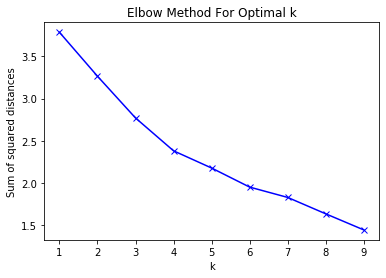

In [25]:
# Elbow method to find optimal K
import matplotlib.pyplot as plt

x = sydney_grouped.drop('Neighbourhood', 1)

Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, random_state=5)
    km = km.fit(x)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The optimal k seems to be 4, but just to be certain we will check using another method.

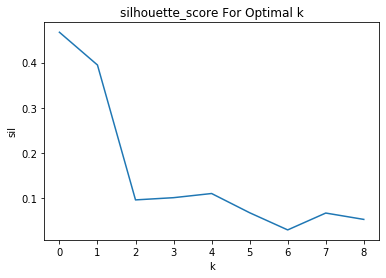

In [26]:
# Silhouette score method to find optimal K
from sklearn.metrics import silhouette_score

sil = []
kmax = 10

# minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k, random_state=5).fit(x)
  labels = kmeans.labels_
  sil.append(silhouette_score(x, labels, metric = 'euclidean'))

plt.plot(sil)
plt.xlabel('k')
plt.ylabel('sil')
plt.title('silhouette_score For Optimal k')
plt.show()

We can see that the graph reaches its highest peak at k=4.

**Cluster neighbourhoods by _k-means_ into 4 clusters**

In [27]:
# set number of clusters
kclusters = 4

sydney_grouped_clustering = sydney_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sydney_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 0], dtype=int32)

**Create a new data frame that includes the cluster as well as the top 10 venues for each neighborhood**

In [28]:
# rename data frame to merge on common key
df_sydney3 = df_sydney3.rename(columns={'Borough': 'Neighbourhood'})

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sydney_merged = df_sydney3

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
sydney_merged = sydney_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

sydney_merged.head() # check the cluster labels column!

,State/Territory,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,New South Wales,Ashfield,-33.8889,151.1249,1.0,Dumpling Restaurant,Chinese Restaurant,Platform,Shanghai Restaurant,Café,Supermarket,Electronics Store,Japanese Restaurant,Asian Restaurant,Coffee Shop
1,New South Wales,Auburn,-33.8606,151.0247,1.0,Playground,Garden,Tennis Court,Café,Wine Bar,Discount Store,Electronics Store,Dumpling Restaurant,Dry Cleaner,Donut Shop
2,New South Wales,Bankstown,-33.9182,151.0350,1.0,Vietnamese Restaurant,Café,Sports Bar,Department Store,Fast Food Restaurant,Convenience Store,Coffee Shop,Chinese Restaurant,Steakhouse,Grocery Store
3,New South Wales,Baulkham Hills,-33.7619,150.9929,0.0,Café,Pizza Place,Supermarket,Pharmacy,Dessert Shop,Dumpling Restaurant,Shopping Mall,Burger Joint,Food Court,Fast Food Restaurant
4,New South Wales,Blacktown,-33.7668,150.9053,1.0,Fast Food Restaurant,Juice Bar,Sandwich Place,Coffee Shop,Supermarket,Convenience Store,Park,Café,Portuguese Restaurant,Chinese Restaurant


In [29]:
# Botany Bay and Warringah have NaN values, so we drop them
sydney_merged = sydney_merged.dropna()

In [30]:
# change cluster values to integer
sydney_merged['Cluster Labels'] = sydney_merged['Cluster Labels'].astype(int)

**Let's find some labels for our clusters by creating a barplot of the most common venues to see how we can label them.**

In [31]:
top_venue_count = sydney_merged
top_venue_count = top_venue_count.drop(['State/Territory','Neighbourhood','Latitude','Longitude'], axis=1)
top_venue_count = top_venue_count.groupby(['Cluster Labels', '1st Most Common Venue']).size().reset_index(name='Count')
top_venue_count

,Cluster Labels,1st Most Common Venue,Count
0,0,Beach,1
1,0,Café,13
2,1,Café,4
3,1,Coffee Shop,1
4,1,Department Store,1
5,1,Dumpling Restaurant,1
6,1,Fast Food Restaurant,5
7,1,Korean Restaurant,1
8,1,Pizza Place,2
9,1,Playground,2


Let's transpose the data frame so that the columns are 1st Most Common Venue

In [32]:
cluster_venue = top_venue_count.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Count')
# change NaN values to 0
cluster_venue = cluster_venue.fillna(0).astype(int).reset_index(drop=True)
cluster_venue

1st Most Common Venue,Beach,Café,Coffee Shop,Department Store,Dumpling Restaurant,Fast Food Restaurant,Korean Restaurant,Nature Preserve,Pizza Place,Playground,Supermarket,Thrift / Vintage Store,Vietnamese Restaurant
0,1,13,0,0,0,0,0,0,0,0,0,0,0
1,0,4,1,1,1,5,1,0,2,2,1,0,2
2,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

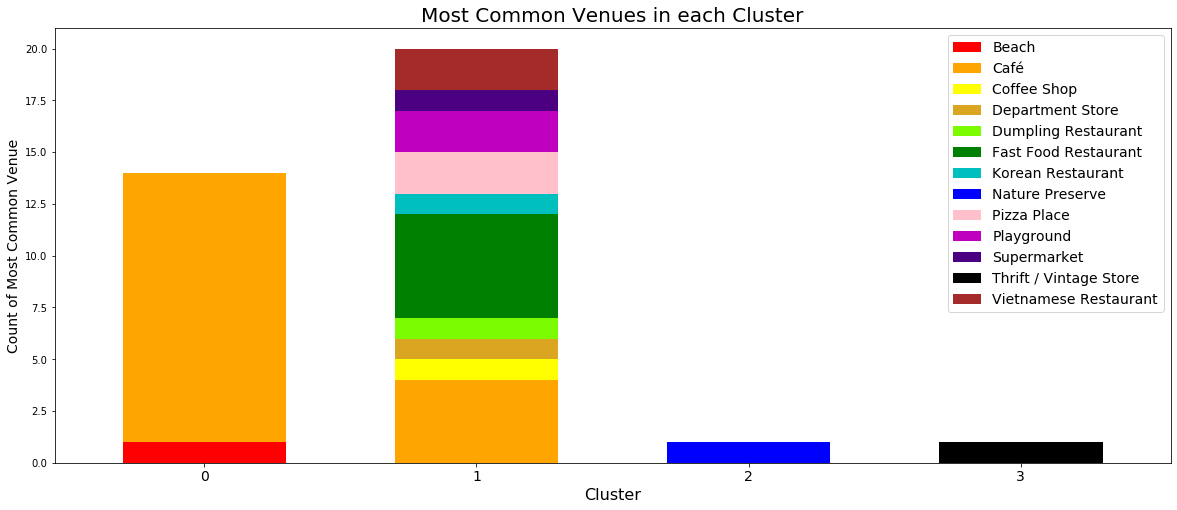

In [33]:
# Create a bar chart of most common venues of each cluster
my_colors = ['r','orange','yellow','goldenrod','lawngreen','g','c','b','pink','m','indigo','k','brown']
cv_plot = cluster_venue.plot(kind='bar', stacked=True,
                            figsize=(20,8), color=my_colors,
                            width=0.6)
plt.title("Most Common Venues in each Cluster", fontsize=20)
plt.xlabel("Cluster", fontsize=16)
plt.ylabel("Count of Most Common Venue", fontsize=14)
plt.legend(labels=cluster_venue.columns, fontsize=14)
plt.xticks(rotation=0, fontsize=14)

**From analysing the stacked bar chart and the top 10 venues, we can generalise each cluster and label them.**

In [34]:
cluster_label = {'Cluster':[0,1,2,3], 'Label':['Numerous Cafe Venues', 'Multiple Restaurant/Cafe Venues and Shops', 'Nature Reserve Venues', 'Thrift Stores and Park Venues']}
cluster_label = pd.DataFrame(data=cluster_label)
cluster_label

,Cluster,Label
0,0,Numerous Cafe Venues
1,1,Multiple Restaurant/Cafe Venues and Shops
2,2,Nature Reserve Venues
3,3,Thrift Stores and Park Venues


Let's also add the top 2 venues for each borough on our map so we can see more information.

In [35]:
top_2 = sydney_venues.groupby(['Neighbourhood','Venue Category']).size().reset_index(name='Count')
top_2 = top_2.sort_values(['Neighbourhood','Count'], ascending=False).groupby('Neighbourhood').head(2).reset_index(drop=True)
# new column
top_2['Top Venues'] = top_2['Count'].map(str) + " " + top_2['Venue Category']
top_2 = top_2.groupby(['Neighbourhood'])['Top Venues'].apply(", ".join).reset_index()
top_2.head()

,Neighbourhood,Top Venues
0,Ashfield,"3 Chinese Restaurant, 3 Dumpling Restaurant"
1,Auburn,"2 Playground, 1 Café"
2,Bankstown,"9 Vietnamese Restaurant, 5 Café"
3,Baulkham Hills,"4 Café, 2 Pizza Place"
4,Blacktown,"6 Fast Food Restaurant, 2 Coffee Shop"


**Merge new variables (_Label_ and _Top Venues_) into our final data frame**

In [36]:
df_sydney4 = sydney_merged.merge(top_2[['Neighbourhood', 'Top Venues']], left_on='Neighbourhood', right_on='Neighbourhood')
df_sydney4 = df_sydney4.merge(cluster_label[['Cluster', 'Label']], left_on='Cluster Labels', right_on='Cluster')
df_sydney4 = df_sydney4.drop(['Cluster'], axis=1)
df_sydney4.head()

,State/Territory,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Top Venues,Label
0,New South Wales,Ashfield,-33.8889,151.1249,1,Dumpling Restaurant,Chinese Restaurant,Platform,Shanghai Restaurant,Café,Supermarket,Electronics Store,Japanese Restaurant,Asian Restaurant,Coffee Shop,"3 Chinese Restaurant, 3 Dumpling Restaurant",Multiple Restaurant/Cafe Venues and Shops
1,New South Wales,Auburn,-33.8606,151.0247,1,Playground,Garden,Tennis Court,Café,Wine Bar,Discount Store,Electronics Store,Dumpling Restaurant,Dry Cleaner,Donut Shop,"2 Playground, 1 Café",Multiple Restaurant/Cafe Venues and Shops
2,New South Wales,Bankstown,-33.9182,151.0350,1,Vietnamese Restaurant,Café,Sports Bar,Department Store,Fast Food Restaurant,Convenience Store,Coffee Shop,Chinese Restaurant,Steakhouse,Grocery Store,"9 Vietnamese Restaurant, 5 Café",Multiple Restaurant/Cafe Venues and Shops
3,New South Wales,Blacktown,-33.7668,150.9053,1,Fast Food Restaurant,Juice Bar,Sandwich Place,Coffee Shop,Supermarket,Convenience Store,Park,Café,Portuguese Restaurant,Chinese Restaurant,"6 Fast Food Restaurant, 2 Coffee Shop",Multiple Restaurant/Cafe Venues and Shops
4,New South Wales,Burwood,-33.8774,151.1037,1,Café,Chinese Restaurant,Coffee Shop,Noodle House,Supermarket,Juice Bar,Department Store,Pharmacy,Fast Food Restaurant,Sandwich Place,"5 Café, 4 Chinese Restaurant",Multiple Restaurant/Cafe Venues and Shops


If there are any display issues with é for Café, you can transfer to csv and use find and replace. You can find this data set [here](https://github.com/ngoharry19/Coursera_Capstone/blob/master/sydney_merged_data.csv).

In [37]:
# df_sydney4.to_csv('sydney_merged_data.csv')
df_sydney5 = pd.read_csv('sydney_merged_data.csv')

## Results and Discussion <a name="results"></a>

**Finally, let's create our final map displaying clusters with information**

In [38]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, lbl, top_v in zip(
        df_sydney5['Latitude'], 
        df_sydney5['Longitude'], 
        df_sydney5['Neighbourhood'], 
        df_sydney5['Cluster Labels'],
        df_sydney5['Label'],
        df_sydney5['Top Venues']):
    label = folium.Popup(str(poi) + ', ' + ' Cluster ' + str(cluster) + ' - ' + str(lbl) + ' | ' + str(top_v), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

The results of K-means clustering of a total of 36 neighbourhoods depict 2 major clusters and 2 single neighbourhood clusters. From examining the clusters, we found that:
* **Cluster 0** - abundance of cafés can be found at these locations, with 2 unique locations (Manly and Sutherland Shire, in this case, Cronulla) having beaches
* **Cluster 1** - wide variety of social areas, shopping stores and restaurants/cafés
* **Cluster 2** - surrounded by nature reserves (Ku-ring-gai)
* **Cluster 3** - consists of a park and thrift/vintage store (Holroyd)

These clusters could have been more unique with more characteristics by including more neighbourhoods/council areas. A one km radius around the coordinates for each neighbourhood may not have been large enough to capture information about the area.    
For example, only 2 venues were found around the locations for clusters 2 and 3. This could be improved by choosing better coordinates such that more venues would be enclosed. Increasing the radius of the circles would also capture more information about other venues within the areas.

It is recommended for people looking to visit or live in Sydney NSW to research more about the neighbourhoods to investigate whether the areas suit their lifestyle or culture. The red dots (Cluster 0) are mostly closer to the CBD area of Sydney, with the areas being characterised by café venues. The purple dots (Cluster 1) are further out from Sydney CBD, with the areas being characterised by their variety of food venues. By closer inspection, some areas are uniquely identified by the number of restaurants from a specific cuisine. For example, our analysis captured Italian restaurants (7) at Leichhardt, Vietnamese restaurants (8) at Marrickville and Korean restaurants (15) at Strathfield.

From analysing the top venues at different neighbourhoods, this resulted in exploring many areas characterised by cuisines and cafés. Choosing an area to reside in based on this factor alone is not optimal but could help specific groups of people looking for different areas for social gatherings and food.

## Conclusion <a name="conclusion"></a>

People looking to become residents and other stakeholders could choose an optimal location in Sydney NSW based on their interests such as the cuisine of food at restaurants, the number of café venues or being near beaches and parks. However, this is not recommended as there are a wide range of factors that come into play when looking for an area to visit or live in. Clustering by top venues could be useful for people looking to open a restaurant in areas where the cuisine is distinctive from other restaurants in the area. The analysis performed in the report has showcased some unique venues for each cluster.

Overall, the final decision to find an optimal location for a new resident will be made by the individuals themselves. As well as finding about how the neighbourhoods are characterised by the number of venues, they should also consider other factors such as transport, housing prices and access to different necessities.